# DELETWEET TEXT MINING

#### *TODO:*
  * don't pull out text emojis
  * count links as percentage of tokens
  * use string.punctuation and add/subtract instead of custom list

## *INTRODUCTION*

There are 67,756 tweets in this subset of the [Politwoops](https://projects.propublica.org/politwoops/) dataset, which is a collection of tweets deleted by US politician's while they were in office. The tweets in the dataset analyzed here were gathered from Nov. 17, 2011 - Feb 3, 2017. The database contains 11 fields:

* id: unique id for the tweet [int]
* user_name: twitter username, or author, of the tweet [str]
* content: text content of the tweet [str]
* created: date tweet was originally created [str; format ‘%m/%d/%Y %H:%M:S’]
* modified: date tweet was last modified, in this case deleted [str; format ‘%m/%d/%Y %H:%M:S’]
* tweet: the original tweet object from the Twitter Streaming API [json]
* state: two letter code for politician's state [str]
* party_id - number corresponding to politician's political party [int]
  * 1 - Democrat
  * 2 - Republican
  * 3 - Independent
  * 4 - Other
* last_name - politician's last name [str]
* first_name - politician's first name [str]
* middle_name - politician's middle name

In [33]:
import json
import pandas
import nltk
import matplotlib
from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt
from wordcloud import WordCloud

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]

## *PARSE AND TOKENIZE TEXT*

Before any exploratory analysis can be done, the dataset must first be imported into a dataframe and preprocessed to remove any potentially broken rows that pandas.read_csv missed.

In [3]:
# import dataset and remove bad rows
deletweet = pandas.read_csv('../../deletweet/data/deleted_tweets.csv', error_bad_lines=False)

bad_rows = []

for i in range(len(deletweet)):
    if type(deletweet['tweet'][i]) != str:
        bad_rows.append(i)
    else:
        tweet = json.loads(deletweet['tweet'][i])
        if type(tweet) != dict:
            bad_rows.append(i)

deletweet.drop(deletweet.index[bad_rows], inplace=True)
deletweet.reset_index(inplace=True, drop=True)

# export cleaned dataframe to csv to allow easier future importing
# deletweet.to_csv('../../deletweet/data/deleted_tweets_cleaned.csv', index=False)

b'Skipping line 1157: expected 11 fields, saw 141\nSkipping line 2263: expected 11 fields, saw 77\nSkipping line 2319: expected 11 fields, saw 92\nSkipping line 4631: expected 11 fields, saw 129\nSkipping line 8260: expected 11 fields, saw 89\nSkipping line 8823: expected 11 fields, saw 84\nSkipping line 8824: expected 11 fields, saw 129\nSkipping line 10197: expected 11 fields, saw 131\nSkipping line 10278: expected 11 fields, saw 123\nSkipping line 10297: expected 11 fields, saw 123\nSkipping line 10311: expected 11 fields, saw 123\nSkipping line 10401: expected 11 fields, saw 79\nSkipping line 10430: expected 11 fields, saw 154\nSkipping line 10495: expected 11 fields, saw 92\nSkipping line 12989: expected 11 fields, saw 77\nSkipping line 14473: expected 11 fields, saw 73\nSkipping line 16741: expected 11 fields, saw 79\nSkipping line 22015: expected 11 fields, saw 81\nSkipping line 22322: expected 11 fields, saw 123\nSkipping line 22957: expected 11 fields, saw 74\nSkipping line 24

A simple describe() gives us an informative overview of the features in the dataset.

For example we can see that each tweet's id is unique, which means we can use it as a unique identifier if needed. This also shows us that we have 67,756 tweets in the dataset. The 'content' field shows us that not every tweet's text is unique, and in fact the most frequently deleted tweet has been posted and taken down 74 times. The state with the most deleted tweets is California, which makes sense as it is one of the most populous states in the US, and as such has a proportionally high number of elected officials. The political party with the most deletions is Republican.

The fields 'first_name', 'last_name', and 'user_name' yield some interesting information: the most common first name, Tim, obviously represents more than one politician in the dataset since the 2,315 deletions attributed to Tim are more than the 1,310 deletions by the most common username in the dataset. But the combination of the most common first and last name - Tim Griffin - does actually correspond to the most most frequently appearing username: TGforArkansas. As we'll see later, one of the most frequent terms in the processed dataset (with stopwords and punctuation removed) is the hashtag #tg4lg, which is equivalent to 'Tim Griffin for Lieutenant Governor'.

In [7]:
deletweet.describe()

,id,user_name,content,created,modified,tweet,state,party_id,last_name,first_name,middle_name
count,67756,67756,67756,67756,67756,67756,67353,67756,67754,67754,5076
unique,67756,1647,67030,67475,61895,67756,54,7,948,465,36
top,350310632161148928,TGforArkansas,"RT @derGeruhn: &lt;script class=""xss""&gt;$('.x...",01/29/2015 22:46:58,06/29/2012 17:40:51,"{""contributors"": null, ""truncated"": false, ""te...",CA,2,Griffin,Tim,Bernie
freq,1,1310,74,5,10,1,5854,32911,1667,2315,1048


In [8]:
# construct a list of strings to hold the tweet text
tweet_text_raw = []

for i in range(len(deletweet)):
    tweet = json.loads(deletweet['tweet'][i])
    tweet_text_raw.append(tweet['text'])

In [9]:
# number of individual tweets in the dataset
len(tweet_text_raw)

67756

In [10]:
# construct one long string of the dataset's tweet content
tweet_string = ' '.join(tweet_text_raw)

In [11]:
# use the tweet tokenizer provided by NLTK
# preserve_case=False will transform all to lowercase
# strip_handles=True will remove all Twitter usernames from the text (i.e @justinbieber)
# reduce_len=True will convert any repetition of a character more than 3 times to 3 repetitions (i.e. nooooo -> nooo)
tknzr = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokenized = tknzr.tokenize(tweet_string)

In [12]:
# convert to NLTK text object for analysis
text = nltk.Text(tweet_tokenized)

In [13]:
# make set of words for vocab
words = [w.lower() for w in text]
vocab = sorted(set(words))
len(vocab)

102551

In [14]:
# lexical diversity
'{:.2%}'.format(len(vocab) / len(words))

'8.35%'

In [46]:
# remove stopwords, punctuation, numbers
stopwords = nltk.corpus.stopwords.words('english')string.punc
punctuation_etc = ['.', ':', ',', '!', '"', '-', '…', '...', "’", '?', '/', "'", '(', ')', '“', '”', '&', '%']
filtered = [w for w in tweet_tokenized if w.lower() not in stopwords]
filtered = [w for w in filtered if w.lower() not in punctuation_etc]

processed = []

for i in range(len(filtered)):
    try:
        float(filtered[i])
    except ValueError:
        processed.append(filtered[i])


text_filtered = nltk.Text(processed)

In [47]:
# percentage of text remaining after removing stopwords and punctuation
'{:.2%}'.format(len(text_filtered) / len(text))

'56.01%'

In [48]:
# removing numbers from the text resulted in roughly 1,000 less unique words
words_filtered = [w.lower() for w in text_filtered]
vocab_filtered = sorted(set(words_filtered))
len(vocab_filtered)

100998

In [50]:
# lexical diversity of processed text
'{:.2%}'.format(len(vocab_filtered) / len(words_filtered))

'14.69%'

In [51]:
# construct frequency distributions for original and processed texts
fdist = nltk.FreqDist(text)
fdist_filtered = nltk.FreqDist(text_filtered)

In [52]:
# most common words in original text
fdist.most_common(50)

[('.', 50706),
 ('the', 36453),
 ('to', 35796),
 (':', 31383),
 (',', 22924),
 ('in', 19005),
 ('!', 17630),
 ('rt', 17591),
 ('for', 17011),
 ('of', 16543),
 ('a', 15379),
 ('and', 13102),
 ('on', 12671),
 ('at', 9034),
 ('&', 8852),
 ('i', 8481),
 ('is', 8119),
 ('you', 7652),
 ('"', 7642),
 ('with', 7485),
 ('my', 6189),
 ('this', 6128),
 ('our', 5936),
 ('today', 5876),
 ('-', 5362),
 ('…', 5274),
 ('we', 5098),
 ('...', 4698),
 ('s', 4615),
 ('be', 4372),
 ('from', 4273),
 ('’', 4115),
 ('?', 4058),
 ('will', 4055),
 ('/', 4036),
 ('great', 3977),
 ('it', 3649),
 ('your', 3446),
 ("'", 3436),
 ('are', 3422),
 ('that', 3406),
 ('about', 3349),
 ('by', 3198),
 ('have', 3145),
 ('w', 3130),
 ('(', 2721),
 ('out', 2683),
 ('more', 2643),
 ('new', 2540),
 ('as', 2428)]

In [60]:
# most common words in processed text
# these are a vast improvement from the unfiltered corpus for determining overall content
fdist_filtered.most_common(50)

[('rt', 17591),
 ('today', 5876),
 ('great', 3977),
 ('w', 3130),
 ('new', 2540),
 ('day', 2288),
 ('thanks', 2286),
 ('us', 2262),
 ('support', 2241),
 ('$', 2198),
 ('house', 2056),
 ('thank', 1993),
 ('time', 1985),
 ('vote', 1954),
 ('help', 1733),
 ('join', 1695),
 ('bill', 1621),
 ('get', 1527),
 ('watch', 1484),
 ('congress', 1450),
 ('proud', 1402),
 ('work', 1402),
 ('need', 1399),
 ('live', 1332),
 ('morning', 1329),
 ('see', 1287),
 ('tonight', 1277),
 ('state', 1264),
 ('people', 1254),
 ('rep', 1250),
 ('president', 1246),
 ('act', 1241),
 ("it's", 1215),
 ('good', 1194),
 ('one', 1175),
 ('last', 1164),
 ('jobs', 1155),
 ("i'm", 1140),
 ('make', 1135),
 ('happy', 1117),
 ('#tg4lg', 1095),
 ('county', 1088),
 ('via', 1085),
 ('obama', 1076),
 ('first', 1060),
 ('http', 1034),
 ('senate', 1034),
 ('meeting', 1030),
 ('women', 1019),
 ('like', 1012)]

In [54]:
# words longer than 3 characters occurring more than 1000 times
sorted(word for word in set(text_filtered) if len(word) > 3 and fdist_filtered[word] > 1000)

['#tg4lg',
 'bill',
 'congress',
 'county',
 'first',
 'good',
 'great',
 'happy',
 'help',
 'house',
 'http',
 "it's",
 'jobs',
 'join',
 'last',
 'like',
 'live',
 'make',
 'meeting',
 'morning',
 'need',
 'obama',
 'people',
 'president',
 'proud',
 'senate',
 'state',
 'support',
 'thank',
 'thanks',
 'time',
 'today',
 'tonight',
 'video',
 'vote',
 'watch',
 'women',
 'work']

(-0.5, 1599.5, 1199.5, -0.5)

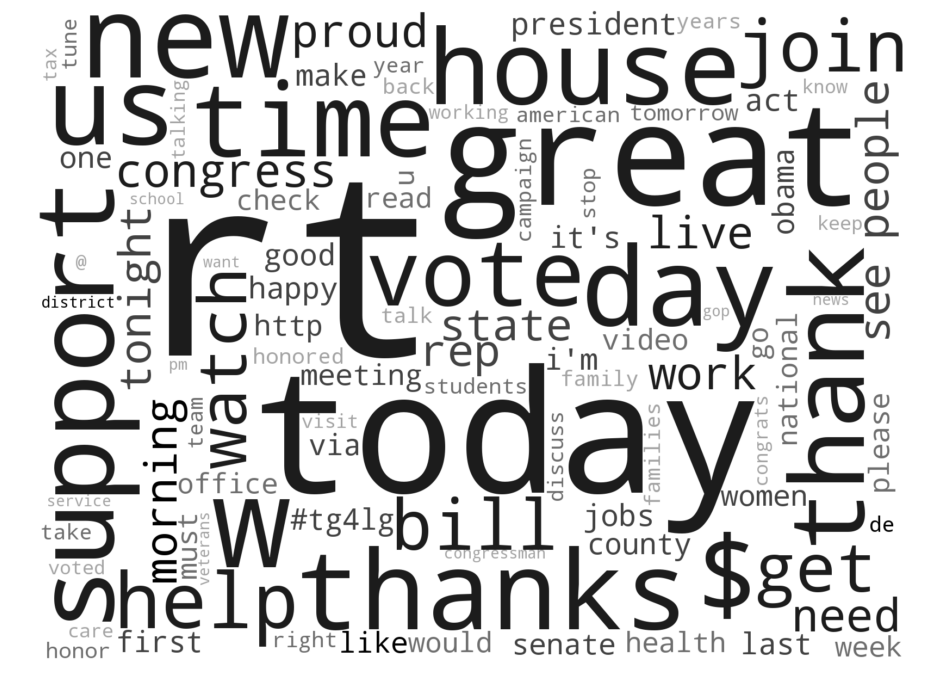

In [70]:
# generate wordcloud out of 100 most frequent words;
# 4 shades of color where color intensity is positively correlated with word frequency

colors = ['#1C1C1C', '#424242', '#6E6E6E', '#A4A4A4']
default_color = 'black'
common = fdist_filtered.most_common(100)
common_list = [common[i][0] for i in range(len(common))]
common_dict = {colors[0]: common_list[0:24], colors[1]: common_list[25:49], colors[2]: common_list[50:74], colors[3]: common_list[75:99]}


# taken from Wordcloud docs example: http://amueller.github.io/word_cloud/auto_examples/colored_by_group.html
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

    
grouped_color_func = SimpleGroupedColorFunc(common_dict, default_color)

wordcloud = WordCloud(width=1600, height=1200, background_color='white', color_func=grouped_color_func, collocations=False).generate_from_frequencies(dict(common))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [30]:
# words frequently appearing together in the text
text.collocations()

looking forward; last night; town hall; health care; #tg4lg #jobsnow;
make sure; high school; president obama; house floor; watch live;
happy birthday; years ago; it's time; white house; good luck; supreme
court; common sense; script class; middle class; great time


In [32]:
# frequency distribition of the frequencies of word lengths
dist_of_dist = nltk.FreqDist(len(w) for w in text)
dist_of_dist_filtered = nltk.FreqDist(len(w) for w in text_filtered)

In [33]:
dist_of_dist.max()

1

In [34]:
dist_of_dist_filtered.max()

5

In [35]:
dist_of_dist.freq(1)

0.18264969246546497

In [36]:
dist_of_dist_filtered.freq(5)

0.15079095870979678